# Pink Floyd Lyrics

##### The goal of the project is to analyse all Pink Floyd lyrics, and then build a model that can return a new song based on user input of 2 key words.

#### imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from numpy import array
import sys

from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional
import re

In [2]:
!pip install openpyxl

In [3]:
file = "../raw_data/pink_floyd_lyrics.csv"
df = pd.read_csv(file, decimal=",")


### Formatting the DataFrame

In [4]:
df.sample(5)

,album,song_title,year,lyrics
50,Meddle,Seamus,1971-10-31,"I was in the kitchen\nSeamus, that’s the dog, ..."
77,Animals,Pigs on the Wing (Part One),1977-01-23,If you didn’t care what happened to me\nAnd I ...
56,Obscured By Clouds,Wot’s... Uh the Deal?,1972-06-02,Heaven sent the promised land\n\nLooks alright...
106,The Wall,The Trial,1979-11-30,"Good morning, Worm your honour\nThe crown will..."
152,The Endless River,Allons-y (1),2014-11-07,NaN


In [5]:

df['year'] = df['year'].apply(lambda x: (x.split('-')[0]))
df.head()

,album,song_title,year,lyrics
0,The Piper at the Gates of Dawn,Astronomy Domine,1967,"""Moon in both [houses]...""...Scorpio, [Arabian..."
1,The Piper at the Gates of Dawn,Lucifer Sam,1967,"Lucifer Sam, siam cat\nAlways sitting by your ..."
2,The Piper at the Gates of Dawn,Matilda Mother,1967,There was a king who ruled the land\nHis Majes...
3,The Piper at the Gates of Dawn,Flaming,1967,Alone in the clouds all blue\nLying on an eide...
4,The Piper at the Gates of Dawn,Pow R. Toc H.,1967,TCH TCH\nAHH (AHH)\nTCH TCH\nAHH AHH\nDoi doi\...


### Explore The Data

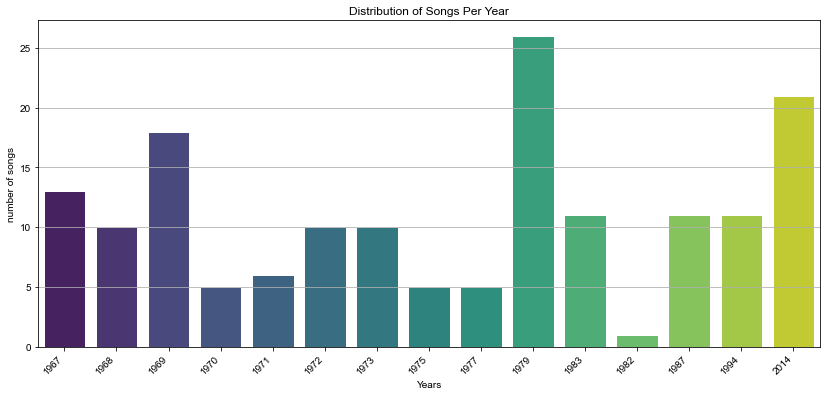

In [6]:
plt.figure(figsize=(14,6),edgecolor='blue')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    )
plt.grid()



    
sns.set_theme(style="darkgrid")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

f = sns.countplot(x="year", 
                  data=df, 
                  palette="viridis", 
                  saturation=0.75, 
                  dodge=True).set(ylabel='number of songs',xlabel='Years', 
                                  title='Distribution of Songs Per Year'
                                                    )
                  
                  


In [35]:
def count_lines(text):
    count,k,p=0,0,0
    for i in text.split('\n'):
        res = re.findall("[a-zA-Z’]+", i)
        if res:
            p+=1
        if len(res)>2:
            k+=1
            count+=len(res)
    if k!=0:
        mean = count/k
    else:
        mean = 2
    total = p
    big_lines = k
    small_lines = (p-k)
  
    return mean,total,big_lines,small_lines

cl = []
for j in range(0,len(df)):
    if type(df.lyrics.iloc[j])==str :
        m,t,bl,sl = count_lines(df.lyrics.iloc[j])
        year = int(df.year.iloc[j])
        if sl!=0:
            l = [m,t,bl,sl,bl/sl,year]
        else:
            l = [m,t,bl,sl,0,year]
        cl.append(l)

df_countlines = pd.DataFrame(cl,columns=['mean_lines','total_lines','big_lines','small_lines','ratio_of_bl_&_sl','year'])
df_countlines.sample(10)

,mean_lines,total_lines,big_lines,small_lines,ratio_of_bl_&_sl,year
45,7.840000,25,25,0,0.0,1972
11,5.576923,27,26,1,26.0,1968
16,8.333333,15,15,0,0.0,1968
30,4.500000,2,2,0,0.0,1970
118,8.529412,17,17,0,0.0,1994
101,7.696970,34,33,1,33.0,1983
50,9.666667,24,24,0,0.0,1973
19,4.416667,12,12,0,0.0,1969
34,10.375000,8,8,0,0.0,1970
60,6.500000,10,10,0,0.0,1975


/Users/kelvinpurdom/.pyenv/versions/lewagon/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


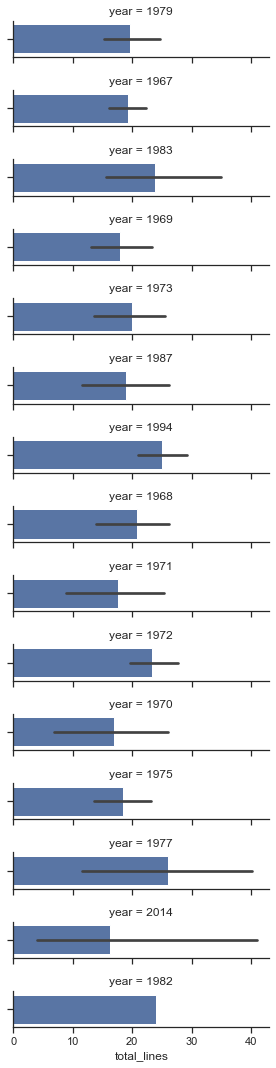

In [36]:
ordered_days = df_countlines.year.value_counts().index
g = sns.FacetGrid(df_countlines, row="year", row_order=ordered_days,
                  height=1, aspect=4,)
g.map(sns.barplot, "total_lines");


### Start Tokenizing

In [9]:
df_clines_gb = df_countlines.groupby(['year']).mean()
df_clines_gb.reset_index(level=0, inplace=True)
df_clines_gb

,year,mean_lines,total_lines,big_lines,small_lines,ratio_of_bl_&_sl
0,1967,5.841000,19.250000,16.416667,2.833333,4.245040
1,1968,6.713571,20.875000,19.875000,1.000000,9.025000
2,1969,8.027602,17.900000,17.400000,0.500000,2.950000
3,1970,7.256591,17.000000,16.800000,0.200000,4.400000
4,1971,7.973779,17.666667,16.833333,0.833333,0.566667
5,1972,6.400952,23.333333,22.166667,1.166667,0.333333
6,1973,8.667927,20.000000,19.111111,0.888889,5.277778
7,1975,6.807713,18.400000,18.200000,0.200000,5.200000
8,1977,7.662409,26.000000,25.600000,0.400000,3.700000
9,1979,7.294332,19.692308,17.461538,2.230769,5.256624


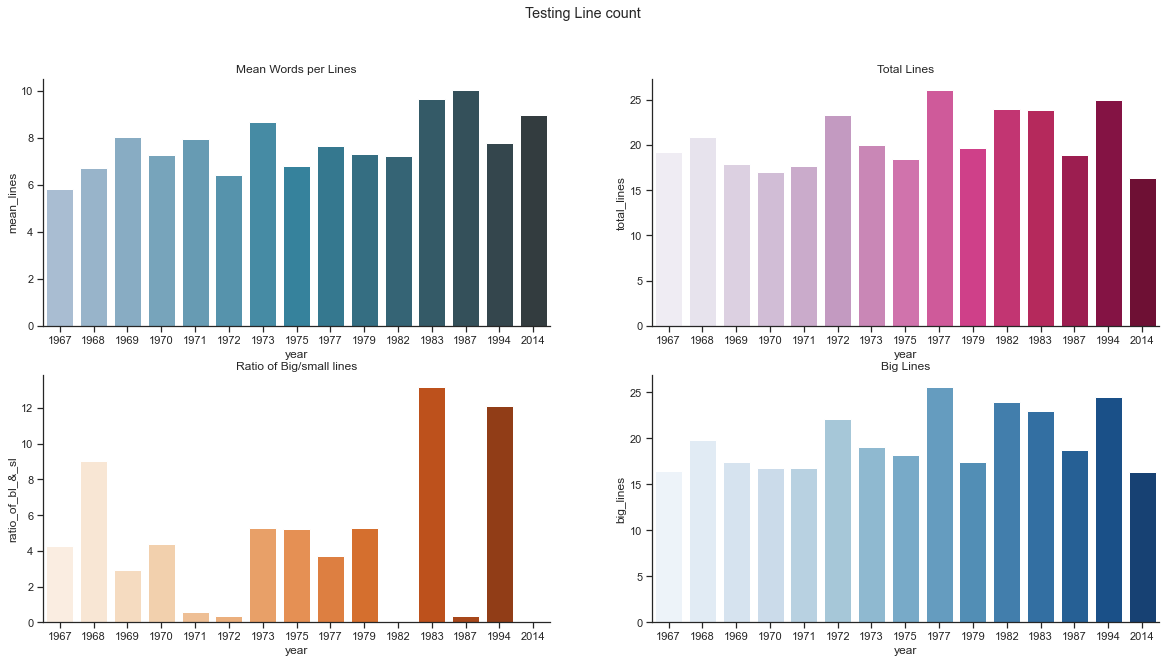

In [31]:
fig,axs = plt.subplots(2,2,figsize=(20,10))
fig.suptitle('Testing Line count')

sns.set_theme(style="darkgrid")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


sns.barplot(ax=axs[0,0],x="year",y='mean_lines', data=df_clines_gb, palette="PuBuGn_d")
axs[0,0].set_title('Mean Words per Lines')
sns.barplot(ax=axs[0,1],x="year",y='total_lines', data=df_clines_gb, palette='PuRd')
axs[0,1].set_title('Total Lines')
sns.barplot(ax=axs[1,1],x="year",y='big_lines', data=df_clines_gb,palette='Blues')
axs[1,1].set_title('Big Lines')
sns.barplot(ax=axs[1,0],x="year",y='ratio_of_bl_&_sl', data=df_clines_gb, palette='Oranges')
axs[1,0].set_title('Ratio of Big/small lines');


In [14]:
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts([df.lyrics.iloc[1].replace('\n',' \n ')])
tokenizer.word_index

{'side': 1,
 'that': 2,
 'cat’s': 3,
 'something': 4,
 'i': 5,
 'can’t': 6,
 'explain': 7,
 'cat': 8,
 'you’re': 9,
 'a': 10,
 'the': 11,
 'be': 12,
 'lucifer': 13,
 'always': 14,
 'by': 15,
 'your': 16,
 'around': 17,
 'sam': 18,
 'siam': 19,
 'sitting': 20,
 'jennifer': 21,
 'gentle': 22,
 'witch': 23,
 'left': 24,
 'he’s': 25,
 'right': 26,
 'oh': 27,
 'no': 28,
 'go': 29,
 'to': 30,
 'sea': 31,
 'hip': 32,
 'ship’s': 33,
 'somewhere': 34,
 'anywhere': 35,
 'at': 36,
 'night': 37,
 'prowling': 38,
 'sifting': 39,
 'sand': 40,
 'hiding': 41,
 'on': 42,
 'ground': 43,
 'he’ll': 44,
 'found': 45,
 'when': 46}

In [15]:
text = df.lyrics.iloc[1].split('\n')
text = [re.sub(r'\d+', '', i) for i in text]
corpus = list(set(text))


In [16]:
corpus


['',
 'Lucifer Sam, siam cat',
 'Jennifer Gentle, you’re a witch',
 'That cat’s something I can’t explain',
 'Somewhere, anywhere',
 'Hiding around on the ground',
 'At night prowling, sifting sand',
 'Always by your side',
 'You’re the left side, he’s the right side',
 'Always sitting by your side',
 'Oh, no!',
 'He’ll be found when you’re around',
 'Be a hip cat, be a ship’s cat',
 'Lucifer, go to sea']

In [17]:
lines=[]

for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    print('--'*25)
    print(token_list)
    print('-'*25)
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        print(n_gram_sequence)
        
lines

--------------------------------------------------
[]
-------------------------
--------------------------------------------------
[13, 18, 19, 8]
-------------------------
[13, 18]
[13, 18, 19]
[13, 18, 19, 8]
--------------------------------------------------
[21, 22, 9, 10, 23]
-------------------------
[21, 22]
[21, 22, 9]
[21, 22, 9, 10]
[21, 22, 9, 10, 23]
--------------------------------------------------
[2, 3, 4, 5, 6, 7]
-------------------------
[2, 3]
[2, 3, 4]
[2, 3, 4, 5]
[2, 3, 4, 5, 6]
[2, 3, 4, 5, 6, 7]
--------------------------------------------------
[34, 35]
-------------------------
[34, 35]
--------------------------------------------------
[41, 17, 42, 11, 43]
-------------------------
[41, 17]
[41, 17, 42]
[41, 17, 42, 11]
[41, 17, 42, 11, 43]
--------------------------------------------------
[36, 37, 38, 39, 40]
-------------------------
[36, 37]
[36, 37, 38]
[36, 37, 38, 39]
[36, 37, 38, 39, 40]
--------------------------------------------------
[14, 15, 16,

[]

In [18]:
def ngram(token_list):
    ng = []
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        ng.append(n_gram_sequence)
    return ng


In [19]:
df.iloc[[0]].lyrics.iloc[0]

'"Moon in both [houses]..."...Scorpio, [Arabian Skies], Libra..."...Pluto was not discovered until 1930..."\nLime and limpid green, a second scene\nA fight between the blue you once knew\nFloating down, the sound resounds\nAround the icy waters underground\nJupiter and Saturn, Oberon, Miranda and Titania\nNeptune, Titan, stars can frighten\n\nBlinding signs flap\nFlicker, flicker, flicker, blam\nPow, pow\nStairway scare Dan Dare who’s there?\n\nLime and limpid green, the sound surrounds\nThe icy waters under\nLime and limpid green, the sound surrounds\nThe icy waters underground'

In [20]:
len(df)

163

In [21]:
def seqform(data):
  
    tokenise = Tokenizer()
    input_sequences = []
    corpus = []
    k=0

    for i in range(0,len(df)):
    
        text = df.iloc[[i]].lyrics.iloc[0]
        if type(text)==float:
            pass
        else:
            text = text.lower().split("\n")
            text = [re.sub(r'\d+', '', i) for i in text]
            text = list(set(text))
            if text==' ':
                pass
            else:
                corpus.extend(text)
            k+=1
            
    tokenise.fit_on_texts(corpus)
    for line in corpus:
        token_list = tokenise.texts_to_sequences([line])[0]
        input_sequences.extend(ngram(token_list))
 
  
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences,
                       maxlen = max_sequence_len, padding='pre'))
        
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    fin_data = pd.DataFrame(np.hstack((predictors, label.reshape(-1,1))),columns=np.hstack((np.arange(1,predictors.shape[1]+1),np.array(['label']))))
    total_words = len(tokenise.word_index) + 1
    print('{} number of lyrics inputted'.format(k))
        
    return fin_data,tokenise,max_sequence_len,total_words,predictors,label

In [22]:
fdf,tokenise,max_sequence_len,total_words,predictors,label = seqform(df)
print(fdf.shape,max_sequence_len,total_words)

125 number of lyrics inputted
(13839, 88) 88 2983


In [23]:
fdf.sample(10)

,1,2,3,4,5,6,7,8,9,10,...,79,80,81,82,83,84,85,86,87,label
6719,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2076,103
5313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,200,17
11843,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,27,150,408
7553,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,41,102,62,411
1667,0,0,0,0,0,0,0,0,0,0,...,1,945,13,49,307,39,5,1526,545,1527
4657,0,0,0,0,0,0,0,0,0,0,...,14,1850,29,41,70,5,1064,8,15,1065
9776,0,0,0,0,0,0,0,0,0,0,...,2,47,1,314,2418,229,4,255,1,1106
5290,0,0,0,0,0,0,0,0,0,0,...,0,0,2,13,16,3,1909,2,313,3
6095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,68,20,148,22,6,1
3457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1738,1739


In [24]:
fdf.to_csv('fin_df.csv',index=False)

### Find Params for the model

In [25]:
print(fdf.shape)
print(fdf.values.max())

(13839, 88)
2982


In [26]:
dataX = [fdf.iloc[i,0:87].tolist() for i in range(0,fdf.shape[0])]
dataY = [fdf.iloc[i,87] for i in range(0,fdf.shape[0])]
print(len(dataX))
print(len(dataY))

13839
13839


In [27]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (13839, 87, 1))

# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [28]:
len(y[0])
print(predictors.shape)
print(label.shape)
print(X.shape,y.shape)
print(total_words,max_sequence_len)

(13839, 87)
(13839,)
(13839, 87, 1) (13839, 2983)
2983 88


### Designing the LSTM Model

In [29]:
model = Sequential()
model.add(Embedding(total_words, 150, input_length=max_sequence_len-1))
# Add an LSTM Layer
model.add(Bidirectional(LSTM(150, return_sequences=True)))  
# A dropout layer for regularisation
model.add(Dropout(0.2))
# Add another LSTM Layer
model.add(LSTM(100)) 
model.add(Dense(total_words/2, activation='relu'))  
# In the last layer, the shape should be equal to the total number of words present in our corpus
model.add(Dense(y.shape[1], activation='softmax'))
#model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')  #(# Pick a loss function and an optimizer)
print(model.summary())

2022-08-09 14:24:46.581748: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 87, 150)           447450    
                                                                 
 bidirectional (Bidirectiona  (None, 87, 300)          361200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 87, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1491)              150591    
                                                                 
 dense_1 (Dense)             (None, 2983)              4450636   
                                                        

In [30]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [33]:
model.fit(X,y, epochs= 10,callbacks=callbacks_list)

Epoch 1/10
  9/433 [..............................] - ETA: 2:21 - loss: 7.9010 - accuracy: 0.0243

KeyboardInterrupt: 

### Training the Model on improved weights

In [56]:
filename = "weights-improvement-10-4.5234.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics='accuracy')
model.fit(X, y, epochs=20, callbacks=callbacks_list)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'weights-improvement-10-4.5234.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [35]:
model.save_weights('my_model_weights.h5')
model.save('my_model.h5')


In [36]:
model.save('saved_model/my_model')

2022-07-28 14:50:34.236334: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


### Func to making lyrics

In [31]:
def make_lyrics(seed_text, next_words):
    pred_index=[]
    for i in range(next_words):
        token_list = tokenise.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list],
                     maxlen=max_sequence_len-1,padding='pre')
        #print(token_list.shape)
        token_list = np.reshape(token_list, (1, max_sequence_len-1, 1))
        predicted = model.predict(token_list, verbose=0)
        predicted_index =  np.argmax(predicted)
        pred_index.append(predicted_index)
        
        output_word = ""
        for word, index in tokenise.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)
    return seed_text


In [32]:
reverse_word_map = dict(map(reversed, tokenise.word_index.items()))
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
pattern_val = [i for i in pattern if i > 0]
print("Seed:")
print(' '.join([reverse_word_map.get(value) for value in pattern_val]))
seed_text = [reverse_word_map.get(value)+' ' for value in pattern_val]

Seed:
a pointless life has


### Playing with the model

In [33]:
line1 = make_lyrics(('living'), 20)

living turns turns turns turns turns signed turns turn turn turn feels suddenly suddenly “…and “…and “…and “…and stile forebodings retire
